Source: https://blog.dominodatalab.com/fitting-gaussian-process-models-python/


In [1]:
import numpy as np
import copy
 
# Using squared exponential covariance K    
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)
    # param[0] is vertical scaling factor
    # param[1] is horizontal scaling factor

# Conditional function (linear algebra B14)
def conditional(x_new, x, y, params):
    # params are scaling factors
    B = exponential_cov(x_new, x, params) # SigmaXY
    C = exponential_cov(x, x, params) # SigmaYY
    A = exponential_cov(x_new, x_new, params) # SigmaXX
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())


1.0


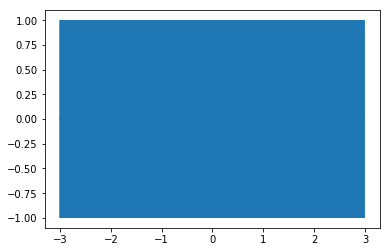

In [2]:
import matplotlib.pylab as plt
%matplotlib inline

θ = [1, 10] # params - scaling factors
σ_0 = exponential_cov(0, 0, θ)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0)
print(σ_0)

Now, we define the underlying function y which we will try to predict. We then take the first sample at an arbitrary point x = 1.0

In [3]:
x = [1.] # Make x float type

def f1(x):
    output = [np.sin(entry) for entry in x]
    return output

y = f1(x)
y

[0.8414709848078965]

Find out what predict() does?

In [4]:
# Update covariance matrix
σ_1 = exponential_cov(x, x, θ)

# predict(i, x, exponential_cov, θ, σ_2, y)
def predict(x, data_x, kernel, params, sigma, data_y):
    """
    x -> x_new, which are all points to be predicted on the plotted graph
    data -> all previous data points
    """
    k = [kernel(x, y, params) for y in data_x] # for each x_new, calculate covariance with all previous data points
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(data_y)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

x_pred = np.linspace(-5, 5, 1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x_pred]


In [5]:
print(σ_1)

[[ 1.]]


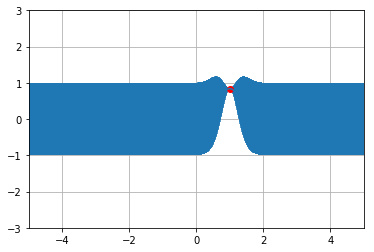

In [6]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

# Change settings of plot
plt.axis([-5, 5, -3, 3])
plt.grid(True)

In [7]:
# Add new datapoint x = 0.7 and recalculate 
x2 = [-0.7]
m2, s2 = conditional(x2, x, y, θ)

# y2 = np.random.normal(m2, s2)

y2 = f1(x2)

x.append(x2[0])

y.append(y2[0])

σ_2 = exponential_cov(x, x, θ)

predictions = [predict(i, x, exponential_cov, θ, σ_2, y) for i in x_pred]


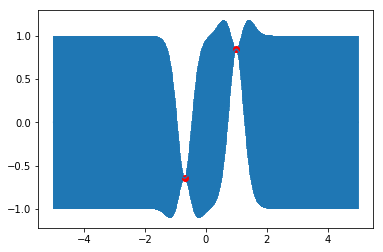

In [8]:
y_pred, sigmas = np.transpose(predictions)

plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)

plt.plot(x, y, "ro")


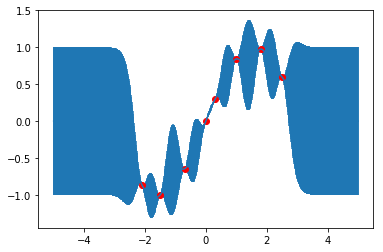

In [9]:
x_more = [-2.1, -1.5, 0.0, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, θ)
# y_more = np.random.multivariate_normal(mu, s)
y_more = f1(x_more)

x += x_more
y += y_more
σ_new = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")


In [10]:
print(x)
print(y)

[1.0, -0.7, -2.1, -1.5, 0.0, 0.3, 1.8, 2.5]
[0.8414709848078965, -0.64421768723769102, -0.86320936664887371, -0.99749498660405445, 0.0, 0.29552020666133955, 0.97384763087819515, 0.59847214410395644]


# Implementing Acquisitions Functions

Probability of Improvement (PI)

Expected Improvement (EI)

In [11]:
def f2(x):
    output = [np.cos(entry) - 0.1*entry**2 - 0.6*entry for entry in x]
    return output

In [12]:
# Restarting x points
x = [0.1, -1.1]
y = f2(x)

σ_new = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)

Text(0.5,1,'Sigmas')

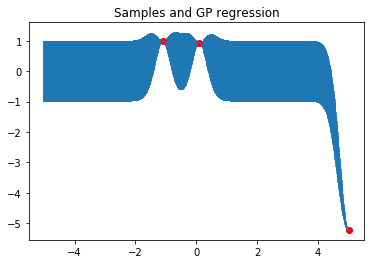

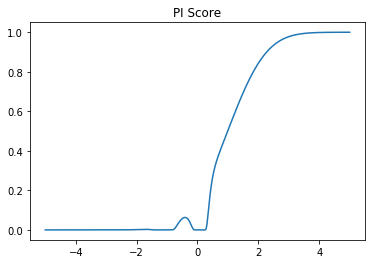

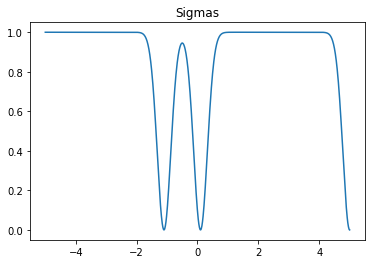

In [13]:
from scipy.stats import norm

current_best_y = max(y_pred)
PI = norm.cdf((x_pred - current_best_y) / sigmas)
max_index = np.argmax(PI)
new_x = [x_pred[max_index]]
new_y = f2(new_x)

if new_x in x:
    print("New point is same")
else: 
    x += new_x
    y += new_y
σ_new = exponential_cov(x, x, θ)
predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)

plt.figure(1)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.title("Samples and GP regression")
plt.plot(x, y, "ro")

plt.figure(2)
plt.title("PI Score")
plt.plot(x_pred, PI)

plt.figure(3)
plt.plot(x_pred, sigmas)
plt.title("Sigmas")

In [14]:
sigmas[-2]

0.0010015011666231199

In [15]:
def PI(x_pred, current_best_y, sigmas):
    # Predicted improvement acquisition function
    PI = norm.cdf((x_pred - current_best_y) / sigmas)
    max_index = np.argmax(PI)
    return max_index

def EI(x_pred, current_best_y, sigmas):
    # Expected improvement acquisition function
    numerator = (x_pred - current_best_y) * norm.cdf((x_pred - current_best_y) / sigmas) 
    denominator = sigmas * norm.pdf((x_pred - current_best_y) / sigmas)
    EI = numerator/denominator
    chosen_index = np.argmax(EI)
    return chosen_index

def UCB(x_pred, current_best_y, sigmas):
    return 0

def BO(x, test_func, budget = 5, acq_func = PI, kernel = exponential_cov, kernel_pars = θ):
    x_pred = np.linspace(-3, 3, 1000)
    improvement = True
    
    # Repeat until run out of budget or no further improvement possible
    while budget > 0 and improvement == True:
        budget -= 1
        
        # Finds new_x with largest PI. If starting from no samples, x_new defaults as 0.0
        if len(x) == 0:
            new_x = [0.0] # default value
            new_y = test_func(new_x)

        else:
            y = test_func(x)
            σ = exponential_cov(x, x, θ)
            predictions = [predict(i, x, exponential_cov, θ, σ, y) for i in x_pred]
            y_pred, sigmas = np.transpose(predictions)
            current_best_y = max(y)
            chosen_index = acq_func(x_pred, current_best_y, sigmas)
            new_x = [x_pred[chosen_index]]
            print(chosen_index)
            print("New sample point: %f" % new_x[0])
            PI = norm.cdf((x_pred - current_best_y) / sigmas)
            plt.figure()
            plt.plot(x_pred, PI)
            new_y = test_func(new_x)
        
        # If PI suggests previously sampled point, no further improvement possible
        if new_x in x:
            x = x
            y = y
            improvement = False
            print("No further improvement expected. Ending sampling.")
        else:
            x += new_x
            y += new_y
    
    print("Maximum y estimate = %f" % max(y))
    print("This is at point = %f" % x[np.argmax(y)])
    plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
    plt.plot(x, y, "ro")

c:\users\jianhong\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


135
New sample point: -2.189189


c:\users\jianhong\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
c:\users\jianhong\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
c:\users\jianhong\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


105
New sample point: -2.369369


c:\users\jianhong\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


72
New sample point: -2.567568
37
New sample point: -2.777778
2
New sample point: -2.987988
0
New sample point: -3.000000
1
New sample point: -2.993994
0
New sample point: -3.000000
No further improvement expected. Ending sampling.
Maximum y estimate = 0.992596
This is at point = -1.100000


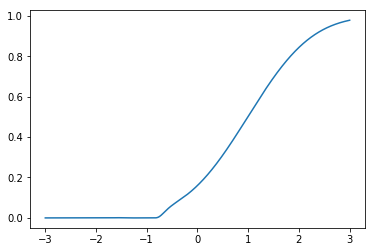

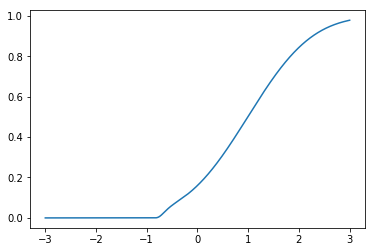

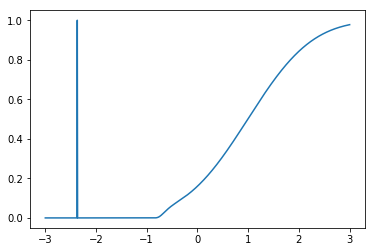

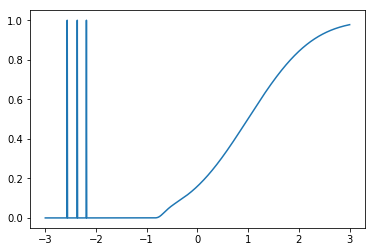

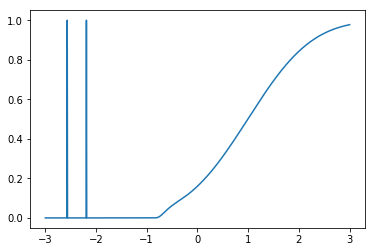

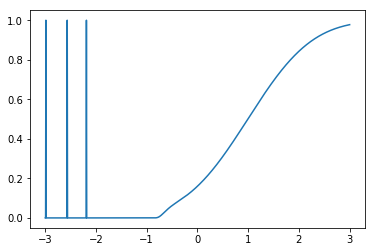

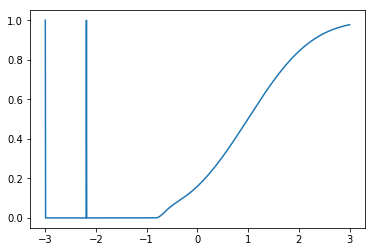

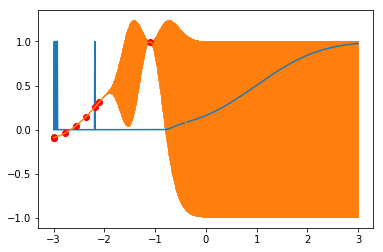

In [18]:
starting_x = [-1.1, -2.1]

BO(starting_x, f2, acq_func = EI, budget = 10)

Max x:  -0.515515515516
Max y:  1.15277238195


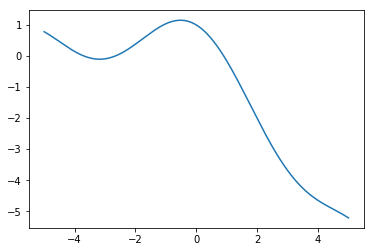

In [17]:
x_pred = np.linspace(-5, 5, 1000)
plt.plot(x_pred, f2(x_pred))
ind = np.argmax(f2(x_pred))
print("Max x: ", x_pred[ind])
print("Max y: ", max(f2(x_pred)))

Expected Improvement 